In [701]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
%matplotlib inline

## Load Data & Convert
Data conversions applied statically to the entire dataset (train & test) so the converted features are usable by the learning algorithm.

These conversions are:
- Converting string to numeric
- Converting categorical strings to categorical type
- For `Age`, removing some spurious values
- Ordinal encodings -- convert strings for ordered categories to ordinals

The only input to these conversions is the feature value for one row, so there is no issue with leakage.

In [702]:
df_2020 = pd.read_csv(r'data\StackOverflow\developer_survey_2020\survey_results_public.csv')

In [703]:
# Columns of interest
cols_of_interest = ['JobSat', 'DevType', 'Hobbyist', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'Gender', 'EdLevel', 
                    'OrgSize', 'NEWEdImpt', 'NEWLearn', 'NEWOvertime', 'UndergradMajor', 'Country', 'ConvertedComp']

# We are only interested in rows with values for both DevType and JobSat 
df_20_cnvrtd = df_2020.dropna(subset=['DevType', 'JobSat'])[cols_of_interest].copy()

In [588]:
df_20_cnvrtd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44546 entries, 0 to 64154
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JobSat          44546 non-null  object 
 1   DevType         44546 non-null  object 
 2   Hobbyist        44546 non-null  object 
 3   Age             35921 non-null  float64
 4   Age1stCode      44340 non-null  object 
 5   YearsCode       44241 non-null  object 
 6   YearsCodePro    44158 non-null  object 
 7   Gender          39232 non-null  object 
 8   EdLevel         43749 non-null  object 
 9   OrgSize         43627 non-null  object 
 10  NEWEdImpt       43693 non-null  object 
 11  NEWLearn        41107 non-null  object 
 12  NEWOvertime     42546 non-null  object 
 13  UndergradMajor  41270 non-null  object 
 14  Country         44546 non-null  object 
 15  ConvertedComp   34325 non-null  float64
dtypes: float64(2), object(14)
memory usage: 5.8+ MB


### Hobbyist
Has values "Yes"/"No" -- will mark as categorical. ML library I am using (CatBoost) has good support for categorical features.

In [418]:
df_20_cnvrtd.Hobbyist.isna().sum()

0

In [589]:
# CatBoost doc says pandas.Categorical type speeds up preprocessing
df_20_cnvrtd.Hobbyist = df_20_cnvrtd.Hobbyist.fillna('NoEntry').astype('category')

In [420]:
df_20_cnvrtd.Hobbyist.head()

0    Yes
1     No
5     No
6    Yes
7    Yes
Name: Hobbyist, dtype: category
Categories (2, object): [No, Yes]

### Age
Will fill nan's with mean/median value. Nontrivial number of NaNs here, but making a guess here that knowledge of choice to not respond will not be helpful to our model (and I'm not interested enough in this variable at this stage to pursue a more sophisticated imputation technique.)

In [421]:
df_20_cnvrtd[df_20_cnvrtd.Age < 16][['JobSat', 'DevType', 'Hobbyist', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'EdLevel']]

JobSat  \
5000                       Very satisfied   
18702                      Very satisfied   
20042                   Very dissatisfied   
20176                      Very satisfied   
20230                  Slightly satisfied   
20779                      Very satisfied   
25061                  Slightly satisfied   
29135               Slightly dissatisfied   
30810                      Very satisfied   
34842                  Slightly satisfied   
50812                  Slightly satisfied   
54687                   Very dissatisfied   
55627  Neither satisfied nor dissatisfied   
58292                  Slightly satisfied   
61073                      Very satisfied   

                                                 DevType Hobbyist   Age  \
5000   Designer;Developer, back-end;Developer, front-...      Yes  15.0   
18702  Developer, desktop or enterprise applications;...      Yes  15.0   
20042  Data or business analyst;Database administrato...      Yes   1.0   
20176          Developer, back-end;Developer, full-stack       No  15.0   
20230  Database administrator;Designer;Developer, bac...      Yes  15.0   
20779  Database administrator;Developer, back-end;Dev...      Yes  15.0   
25061                              Developer, full-stack      Yes   1.0   
29135  Designer;Developer, back-end;Developer, deskto...      Yes  13.0   
30810  Developer, back-end;Developer, front-end;Devel...      Yes  10.0   
34842  Database administrator;Developer, back-end;Dev...      Yes  15.0   
50812  Designer;Developer, back-end;Developer, deskto...      Yes  15.0   
54687  Academic researcher;Data or business analyst;D...      Yes   1.0   
55627  Academic researcher;Data or business analyst;D...      Yes  12.0   
58292  Developer, back-end;Developer, front-end;Devel...      Yes   1.0   
61073  Developer, desktop or enterprise applications;...       No  15.0   

                 Age1stCode         YearsCode      YearsCodePro  \
5000                     12                 3                 1   
18702                     9                 6                 1   
20042                    20                 5                 1   
20176                    20                 7                 5   
20230                     9                 7                 3   
20779                     9                 6               NaN   
25061                    12                14                 7   
29135                     7                 6                 3   
30810                    20                 1                 9   
34842                    16                 4                 3   
50812                    10                 5                 2   
54687  Younger than 5 years  Less than 1 year  Less than 1 year   
55627  Younger than 5 years                40                17   
58292  Younger than 5 years                 3                 2   
61073                    11                 3  Less than 1 year   

                                                 EdLevel  
5000                           Primary/elementary school  
18702  Secondary school (e.g. American high school, G...  
20042       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  
20176       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  
20230  Secondary school (e.g. American high school, G...  
20779                          Primary/elementary school  
25061       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  
29135                                                NaN  
30810       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  
34842       Bachelor’s degree (B.A., B.S., B.Eng., etc.)  
50812  Secondary school (e.g. American high school, G...  
54687             I never completed any formal education  
55627    Master’s degree (M.A., M.S., M.Eng., MBA, etc.)  
58292             I never completed any formal education  
61073       Bachelor’s degree (B.A., B.S., B.Eng., etc.)

In [590]:
# Assume any age < 13, > 89 is junk
df_20_cnvrtd.loc[df_20_cnvrtd.Age < 13, 'Age'] = np.nan
df_20_cnvrtd.loc[df_20_cnvrtd.Age > 89, 'Age'] = np.nan

### Age1stCode

Few NaNs here, comfortable filling with mean (done in **Post-Split Data Preparation**.)

In [591]:
def age1stToInt(s):
    if s == 'Younger than 5 years':
        return 4
    elif s == 'Older than 85':
        return 86
    else:
        try:
            return int(s)
        except:
            return np.nan

In [592]:
df_20_cnvrtd.Age1stCode = df_20_cnvrtd.Age1stCode.apply(age1stToInt)

### YearsCode

Few NaNs here, comfortable filling with mean (done in **Post-Split Data Preparation**.)

In [593]:
def durationToNum(s):
    if s == 'Less than 1 year':
        return 0.5
    elif s == 'More than 50 years':
        return 55.0
    else:
        try:
            return float(s)
        except:
            return np.nan

In [594]:
df_20_cnvrtd.YearsCode = df_20_cnvrtd.YearsCode.apply(durationToNum)

### YearsCodePro

Few NaNs here, comfortable filling with mean (done in **Post-Split Data Preparation**.)

In [595]:
df_20_cnvrtd.YearsCodePro = df_20_cnvrtd.YearsCodePro.apply(durationToNum)

### Gender

More NaN here than 'Woman' responses -- will retain "no entry" status in case this is predictive in any way. I'm not concerned about multi responses since they are very fe in number (and gender is not a focus given questions of interest.) Handle multiresponses correctly by providing a unique encoding for each, but don't anticipate significant impact from this choice or instead simplifying categories some way.)

In [597]:
df_20_cnvrtd.Gender.value_counts()

Man                                                            35894
Woman                                                           2863
Non-binary, genderqueer, or gender non-conforming                268
Man;Non-binary, genderqueer, or gender non-conforming             88
Woman;Non-binary, genderqueer, or gender non-conforming           60
Woman;Man                                                         41
Woman;Man;Non-binary, genderqueer, or gender non-conforming       18
Name: Gender, dtype: int64

In [596]:
df_20_cnvrtd.Gender.isna().sum()

5314

In [598]:
# CatBoost doc says pandas.Categorical type speeds up preprocessing
df_20_cnvrtd.Gender = df_20_cnvrtd.Gender.fillna('NoEntry').astype('category')

### UndergradMajor

Designate missing values as a unique category.

In [430]:
df_20_cnvrtd.UndergradMajor.value_counts()

Computer science, computer engineering, or software engineering                   25905
Another engineering discipline (such as civil, electrical, mechanical, etc.)       3810
Information systems, information technology, or system administration              3294
A natural science (such as biology, chemistry, physics, etc.)                      1792
Mathematics or statistics                                                          1473
Web development or web design                                                      1304
A business discipline (such as accounting, finance, marketing, etc.)               1064
A humanities discipline (such as literature, history, philosophy, etc.)             842
A social science (such as anthropology, psychology, political science, etc.)        736
Fine arts or performing arts (such as graphic design, music, studio art, etc.)      602
I never declared a major                                                            295
A health science (such as nursin

In [431]:
df_20_cnvrtd.UndergradMajor.isna().sum()

3276

In [599]:
df_20_cnvrtd.UndergradMajor = df_20_cnvrtd.UndergradMajor.fillna('NoEntry').astype('category')

In [433]:
df_20_cnvrtd.UndergradMajor.head()

0    Computer science, computer engineering, or sof...
1    Computer science, computer engineering, or sof...
5                                              NoEntry
6    Computer science, computer engineering, or sof...
7    Computer science, computer engineering, or sof...
Name: UndergradMajor, dtype: category
Categories (13, object): [A business discipline (such as accounting, fin..., A health science (such as nursing, pharmacy, r..., A humanities discipline (such as literature, h..., A natural science (such as biology, chemistry,..., ..., Information systems, information technology, o..., Mathematics or statistics, NoEntry, Web development or web design]

### Country

Almost 200 possible values here; rely on CatBoost's categorical encoding which in this case would use a sophisticated target encoding algorithm.

In [600]:
df_20_cnvrtd.Country.isna().sum()

0

In [601]:
df_20_cnvrtd.Country = df_20_cnvrtd.Country.astype('category')

### ConvertedComp

In [704]:
# significant fraction of respondents reported no compensation
# CatBoost default encoding of missing numerical values will use a unique value to indicate missing values. I think that 
# is appropriate here, as I'm interested in retaining this non-response information.

In [603]:
df_20_cnvrtd.ConvertedComp.isna().sum()

10221

### Ordinal Encodings: JobSat, EdLevel, OrgSize, NEWEdImpt, NewLearn, NewOvertime
For string features that support ordinal encodings, encode them as such.

Few NaNs here, comfortable filling with mean (done in **Post-Split Data Preparation**.)

In [604]:
import category_encoders as ce

In [605]:
df_20_cnvrtd.OrgSize.value_counts()

20 to 99 employees                                    9488
100 to 499 employees                                  8202
10,000 or more employees                              6011
1,000 to 4,999 employees                              4756
2 to 9 employees                                      4354
10 to 19 employees                                    4079
500 to 999 employees                                  2833
Just me - I am a freelancer, sole proprietor, etc.    2138
5,000 to 9,999 employees                              1766
Name: OrgSize, dtype: int64

In [606]:
df_20_cnvrtd.OrgSize.isna().sum()

919

In [607]:
df_20_cnvrtd.NEWEdImpt.value_counts()

Fairly important                      11628
Very important                        10636
Somewhat important                    10408
Not at all important/not necessary     6864
Critically important                   4157
Name: NEWEdImpt, dtype: int64

In [705]:
df_20_cnvrtd.NEWEdImpt.isna().sum()

853

In [608]:
df_20_cnvrtd.NEWLearn.value_counts()

Once a year             15774
Every few months        13884
Once every few years    10584
Once a decade             865
Name: NEWLearn, dtype: int64

In [706]:
df_20_cnvrtd.NEWLearn.isna().sum()

3439

In [609]:
jobsat_dict = {'Very dissatisfied': 0, 'Slightly dissatisfied': 1, 'Neither satisfied nor dissatisfied': 2,
              'Slightly satisfied': 3, 'Very satisfied': 4}

# idea here is years beyond 7 years of primary/elem
edlevel_dict = {'I never completed any formal education': 0, 
              'Primary/elementary school': 1, 
              'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 4, 
              'Some college/university study without earning a degree': 6,
              'Associate degree (A.A., A.S., etc.)': 6,
              'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 8,
              'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 10,
              'Professional degree (JD, MD, etc.)': 13,
              'Other doctoral degree (Ph.D., Ed.D., etc.)': 13
             }

orgsize_dict = {'Just me - I am a freelancer, sole proprietor, etc.': 1,
                '2 to 9 employees': 5,
                '10 to 19 employees': 15,
                '20 to 99 employees': 60,
                '100 to 499 employees': 300,
                '500 to 999 employees': 750,
                '1,000 to 4,999 employees': 3000,
                '5,000 to 9,999 employees': 7500,
                '10,000 or more employees': 11000}

edimpt_dict = {'Not at all important/not necessary': 0, 
              'Somewhat important': 1, 
              'Fairly important': 2, 
              'Very important': 3,
              'Critically important': 4}

learn_dict = {'Once a decade': 0,
              'Once every few years': 1,
              'Once a year': 2,
              'Every few months': 3}

overtime_dict = {'Never': 0, 
              'Rarely: 1-2 days per year or less': 1, 
              'Occasionally: 1-2 days per quarter but less than monthly': 2, 
              'Sometimes: 1-2 days per month but less than weekly': 3,
              'Often: 1-2 days per week or more': 4
             }

In [610]:
dev_ord_enc = ce.OrdinalEncoder(cols = ['JobSat', 'EdLevel', 'OrgSize', 'NEWEdImpt', 'NEWLearn', 'NEWOvertime'],
                                mapping= [{'col': 'JobSat', 'mapping': jobsat_dict},
                                          {'col': 'EdLevel', 'mapping': edlevel_dict},
                                          {'col': 'OrgSize', 'mapping': orgsize_dict},
                                          {'col': 'NEWEdImpt', 'mapping': edimpt_dict},
                                          {'col': 'NEWLearn', 'mapping': learn_dict},
                                          {'col': 'NEWOvertime', 'mapping': overtime_dict}], 
                                handle_unknown='return_nan')

**Apply Ordinal Encoders**

In [611]:
df_20_cnvrtd = dev_ord_enc.fit_transform(df_20_cnvrtd)

**Test Ordinal Encoders**

In [206]:
df_ordinals = dev_ord_enc.fit_transform(df_20_cnvrtd)

In [207]:
df_ordinals.describe()

JobSat           Age    Age1stCode     YearsCode  YearsCodePro  \
count  44546.000000  35907.000000  44340.000000  44241.000000  44158.000000   
mean       2.632313     32.133932     15.308502     14.091940      8.469688   
std        1.299772      8.599206      4.908608      9.530708      7.813137   
min        0.000000     13.000000      4.000000      0.500000      0.500000   
25%        2.000000     26.000000     12.000000      7.000000      3.000000   
50%        3.000000     30.000000     15.000000     11.000000      6.000000   
75%        4.000000     36.000000     18.000000     19.000000     12.000000   
max        4.000000     89.000000     86.000000     55.000000     55.000000   

            EdLevel       OrgSize     NEWEdImpt      NEWLearn   NEWOvertime  
count  43749.000000  43627.000000  43693.000000  41107.000000  42546.000000  
mean       8.217262   2266.342471      1.881308      2.038193      2.408969  
std        2.008109   3853.306881      1.215125      0.823381      1.305493  
min        0.000000      1.000000      0.000000      0.000000      0.000000  
25%        8.000000     60.000000      1.000000      1.000000      1.000000  
50%        8.000000    300.000000      2.000000      2.000000      3.000000  
75%       10.000000   3000.000000      3.000000      3.000000      4.000000  
max       13.000000  11000.000000      4.000000      3.000000      4.000000

In [208]:
df_ordinals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44546 entries, 0 to 64154
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   JobSat          44546 non-null  int32   
 1   DevType         44546 non-null  object  
 2   Hobbyist        44546 non-null  category
 3   Age             35907 non-null  float64 
 4   Age1stCode      44340 non-null  float64 
 5   YearsCode       44241 non-null  float64 
 6   YearsCodePro    44158 non-null  float64 
 7   Gender          44546 non-null  category
 8   EdLevel         43749 non-null  float64 
 9   OrgSize         43627 non-null  float64 
 10  NEWEdImpt       43693 non-null  float64 
 11  NEWLearn        41107 non-null  float64 
 12  NEWOvertime     42546 non-null  float64 
 13  UndergradMajor  44546 non-null  category
dtypes: category(3), float64(9), int32(1), object(1)
memory usage: 4.0+ MB


In [209]:
df_ordinals.JobSat.value_counts()

4    14394
3    13758
1     7027
2     5691
0     3676
Name: JobSat, dtype: int64

### DevType Encoding
Each respondent can have one or more entry for DevType. 

I tried two different encodings. 

1. Represent the set for a respondent as an integer with a bit turned on for each devType. This will yield a categorical variable with fairly large cardinality. Let CatBoost do its categorical variable target encoding.

2. Use multiple columns -- a dummy variable for each DevType. 

I found better performance with the multiple column option, so I use that in the final version of the model.

In [707]:
from sklearn.base import BaseEstimator, TransformerMixin
from functools import reduce

class DevTypeTransform(BaseEstimator, TransformerMixin):
    """
    Operate on DataFrame with single column, named 'DevType'. (To be used with `make_column_transformer()`.)
    
    Pre: the df does not have any NaN values for DevType.
    """
    
    def __init__(self, all_devtypes, xform_type = 'bitwise'):
        """
        Arguments:
            all_devtypes: DevTypes column in original format (;-delim strings) - must contain all devtypes.
            xform_type: Type of transform to perform on the transform() operation -- either 'bitwise', 
            producing a single integer value for this particular combination of dev types, or 'column', 
            a dummy variable column for each possible dev type.
        """
        
        if xform_type not in ('bitwise', 'column'):
            raise ValueError
        self.xform_type = xform_type
        
        # avoid BaseEstimator warning: "get_params will raise an AttributeError if a parameter cannot be 
        # retrieved as an instance attribute."
        self.all_devtypes=all_devtypes
        
        #
        # Record all the possible dev types
        #
        
        # List of developer types, ordered by descending frequency
        devtype_list = list(
            all_devtypes
            .dropna()
            .str.split(';')
            .explode()
            .value_counts()
            .index)
        # Map devtype string to an int with 1 bit set
        self.devtype_bits = {name: 1<<shiftbits for  shiftbits, name in enumerate(devtype_list)}
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        def dt_list_to_int(dt_list):
            """
            Convert a list of DevType strings to an integer by OR-ing in the corresponding bit for each dev type.
            """
            return reduce(lambda x,y: x|self.devtype_bits[y], dt_list, 0)

        X = X.rename(columns={'DevType':'DevTypeString'})
        X['DevType'] = X.DevTypeString.str.split(';')
        X = (X
             .drop('DevTypeString', axis=1)
            .applymap(dt_list_to_int))
        X.DevType = X.DevType.astype('category')
        
        
        if self.xform_type == 'column':
            # Create a column for each devtype
            self.dt_col_names = []
            for name, bitmask in self.devtype_bits.items():
                col_name = 'DT_'+name
                self.dt_col_names.append(col_name)
                X[col_name] = X.DevType.apply(lambda x: (x & bitmask) > 0)
            
            
        return X.drop('DevType', axis=1)

#### Apply DevType Encoding - Bitwise

In [277]:
dtt = DevTypeTransform(df_2020.DevType)
df_20_cnvrtd.DevType = dtt.fit_transform(df_20_cnvrtd[['DevType']])

In [409]:
df_20_cnvrtd.head(10)

JobSat  DevType Hobbyist   Age  Age1stCode  YearsCode  YearsCodePro  \
0        3       10      Yes   NaN        13.0       36.0          27.0   
1        0       18       No   NaN        19.0        7.0           4.0   
5        3      148       No   NaN        14.0        6.0           4.0   
6        4     4133      Yes   NaN        18.0        6.0           4.0   
7        1    65545      Yes  36.0        12.0       17.0          13.0   
8        0        2       No  30.0        20.0        6.0           4.0   
9        4       82      Yes  22.0        14.0        8.0           4.0   
10       1      525      Yes  23.0        13.0       10.0           2.0   
11       0      132       No  49.0        42.0        7.0           7.0   
12       4      129      Yes  53.0        14.0       35.0          20.0   

     Gender  EdLevel  OrgSize  NEWEdImpt  NEWLearn  NEWOvertime  \
0       Man     10.0      5.0        2.0       2.0          4.0   
1   NoEntry      8.0   3000.0        2.0       2.0          NaN   
5       Man      4.0      NaN        2.0       2.0          0.0   
6   NoEntry      8.0     60.0        3.0       3.0          3.0   
7       Man      8.0     60.0        0.0       2.0          2.0   
8       Man     13.0      1.0        3.0       2.0          2.0   
9       Man     10.0      5.0        2.0       3.0          4.0   
10      Man      8.0  11000.0        3.0       3.0          1.0   
11      Man      6.0      5.0        1.0       1.0          1.0   
12      Man      4.0      5.0        0.0       1.0          1.0   

                                       UndergradMajor  
0   Computer science, computer engineering, or sof...  
1   Computer science, computer engineering, or sof...  
5                                             NoEntry  
6   Computer science, computer engineering, or sof...  
7   Computer science, computer engineering, or sof...  
8   Computer science, computer engineering, or sof...  
9                           Mathematics or statistics  
10  Computer science, computer engineering, or sof...  
11                          Mathematics or statistics  
12                                            NoEntry

#### Apply DevType Encoding - Columns

In [613]:
dtt = DevTypeTransform(df_2020.DevType, xform_type='column')
new_cols = dtt.fit_transform(df_20_cnvrtd[['DevType']])

In [614]:
df_20_cnvrtd_cols = pd.concat([df_20_cnvrtd.drop('DevType', axis=1), new_cols], axis=1)

In [453]:
df_20_cnvrtd_cols.columns

Index(['JobSat', 'Hobbyist', 'Age', 'Age1stCode', 'YearsCode', 'YearsCodePro',
       'Gender', 'EdLevel', 'OrgSize', 'NEWEdImpt', 'NEWLearn', 'NEWOvertime',
       'UndergradMajor', 'DT_Developer, back-end', 'DT_Developer, full-stack',
       'DT_Developer, front-end',
       'DT_Developer, desktop or enterprise applications',
       'DT_Developer, mobile', 'DT_DevOps specialist',
       'DT_Database administrator', 'DT_Designer', 'DT_System administrator',
       'DT_Developer, embedded applications or devices',
       'DT_Data or business analyst',
       'DT_Data scientist or machine learning specialist',
       'DT_Developer, QA or test', 'DT_Engineer, data',
       'DT_Academic researcher', 'DT_Educator',
       'DT_Developer, game or graphics', 'DT_Engineering manager',
       'DT_Product manager', 'DT_Scientist', 'DT_Engineer, site reliability',
       'DT_Senior executive/VP', 'DT_Marketing or sales professional'],
      dtype='object')

In [456]:
devtype_col_names = dtt.dt_col_names
devtype_col_names

['DT_Developer, back-end',
 'DT_Developer, full-stack',
 'DT_Developer, front-end',
 'DT_Developer, desktop or enterprise applications',
 'DT_Developer, mobile',
 'DT_DevOps specialist',
 'DT_Database administrator',
 'DT_Designer',
 'DT_System administrator',
 'DT_Developer, embedded applications or devices',
 'DT_Data or business analyst',
 'DT_Data scientist or machine learning specialist',
 'DT_Developer, QA or test',
 'DT_Engineer, data',
 'DT_Academic researcher',
 'DT_Educator',
 'DT_Developer, game or graphics',
 'DT_Engineering manager',
 'DT_Product manager',
 'DT_Scientist',
 'DT_Engineer, site reliability',
 'DT_Senior executive/VP',
 'DT_Marketing or sales professional']

In [454]:
df_20_cnvrtd_cols.head(9)

JobSat Hobbyist   Age  Age1stCode  YearsCode  YearsCodePro   Gender  \
0        3      Yes   NaN        13.0       36.0          27.0      Man   
1        0       No   NaN        19.0        7.0           4.0  NoEntry   
5        3       No   NaN        14.0        6.0           4.0      Man   
6        4      Yes   NaN        18.0        6.0           4.0  NoEntry   
7        1      Yes  36.0        12.0       17.0          13.0      Man   
8        0       No  30.0        20.0        6.0           4.0      Man   
9        4      Yes  22.0        14.0        8.0           4.0      Man   
10       1      Yes  23.0        13.0       10.0           2.0      Man   
11       0       No  49.0        42.0        7.0           7.0      Man   

    EdLevel  OrgSize  NEWEdImpt  ...  DT_Engineer, data  \
0      10.0      5.0        2.0  ...              False   
1       8.0   3000.0        2.0  ...              False   
5       4.0      NaN        2.0  ...              False   
6       8.0     60.0        3.0  ...              False   
7       8.0     60.0        0.0  ...              False   
8      13.0      1.0        3.0  ...              False   
9      10.0      5.0        2.0  ...              False   
10      8.0  11000.0        3.0  ...              False   
11      6.0      5.0        1.0  ...              False   

    DT_Academic researcher DT_Educator DT_Developer, game or graphics  \
0                    False       False                          False   
1                    False       False                          False   
5                    False       False                          False   
6                    False       False                          False   
7                    False       False                           True   
8                    False       False                          False   
9                    False       False                          False   
10                   False       False                          False   
11                   False       False                          False   

   DT_Engineering manager DT_Product manager DT_Scientist  \
0                   False              False        False   
1                   False              False        False   
5                   False              False        False   
6                   False              False        False   
7                   False              False        False   
8                   False              False        False   
9                   False              False        False   
10                  False              False        False   
11                  False              False        False   

   DT_Engineer, site reliability DT_Senior executive/VP  \
0                          False                  False   
1                          False                  False   
5                          False                  False   
6                          False                  False   
7                          False                  False   
8                          False                  False   
9                          False                  False   
10                         False                  False   
11                         False                  False   

   DT_Marketing or sales professional  
0                               False  
1                               False  
5                               False  
6                               False  
7                               False  
8                               False  
9                               False  
10                              False  
11                              False  

[9 rows x 36 columns]

#### Test DevTypeTransform

In [260]:
test_df = df_20_cnvrtd.loc[:25,:][['DevType']]
test_df

DevType
0   Developer, desktop or enterprise applications;...
1             Developer, full-stack;Developer, mobile
5     Designer;Developer, front-end;Developer, mobile
6   Developer, back-end;Developer, front-end;Devel...
7   Developer, back-end;Developer, desktop or ente...
8                               Developer, full-stack
9   Database administrator;Developer, full-stack;D...
10  Developer, back-end;Developer, desktop or ente...
11                      Designer;Developer, front-end
12                       Designer;Developer, back-end
13  Developer, desktop or enterprise applications;...
15  Database administrator;Developer, back-end;Dev...
16                              Developer, full-stack
17                                Developer, back-end
18                              Developer, full-stack
19      Developer, desktop or enterprise applications
21               Developer, full-stack;Engineer, data
22  Developer, back-end;Developer, desktop or ente...
23                                Developer, back-end
24  Developer, back-end;Developer, full-stack;DevO...
25                              Developer, full-stack

In [274]:
dtt2 = DevTypeTransform(df_2020.DevType)

# fit with full dataset so we create encoding for all dev types
res3 = dtt2.fit_transform(test_df)
res3

DevType
0       10
1       18
5      148
6     4133
7    65545
8        2
9       82
10     525
11     132
12     129
13      12
15    4203
16       2
17       1
18       2
19       8
21    8194
22   37385
23       1
24    8483
25       2

**Validate** the result for a few rows. 

In [266]:
devtype_names = test_df.loc[0,'DevType']
devtype_names, res3.loc[0, 'DevType'], [dtt2.devtype_bits[x] for x in devtype_names.split(';')]

('Developer, desktop or enterprise applications;Developer, full-stack',
 10,
 [8, 2])

In [267]:
devtype_names2 = test_df.loc[21,'DevType']
devtype_names2, res3.loc[21, 'DevType'], [dtt2.devtype_bits[x] for x in devtype_names2.split(';')]

('Developer, full-stack;Engineer, data', 8194, [2, 8192])

## Split Data into Train and Test

In [615]:
X_cvrtd = df_20_cnvrtd.drop('JobSat', axis=1)
y_cvrtd = df_20_cnvrtd[['JobSat']]

In [616]:
X_train, X_test, y_train, y_test = train_test_split(X_cvrtd, y_cvrtd, test_size=0.20, random_state=0)

In [302]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((35636, 13), (8910, 13), (35636, 1), (8910, 1))

In [303]:
X_train

DevType Hobbyist   Age  Age1stCode  YearsCode  YearsCodePro   Gender  \
46714     4096       No  29.0        15.0       15.0           3.0      Man   
22311     2049       No  37.0        18.0        6.0           3.0    Woman   
51725       11      Yes   NaN         8.0       15.0          13.0  NoEntry   
19983        6      Yes  27.0        12.0        9.0           6.0      Man   
16106       29      Yes  24.0        19.0        4.0           1.0      Man   
...        ...      ...   ...         ...        ...           ...      ...   
41407    65562      Yes  42.0        19.0       18.0          15.0      Man   
26771        2      Yes  26.0        10.0       10.0           4.0    Woman   
59720       13      Yes   NaN        19.0        9.0           7.0  NoEntry   
61290        2      Yes   NaN        17.0       20.0          14.0  NoEntry   
3345    295044      Yes  38.0        15.0       15.0          15.0      Man   

       EdLevel  OrgSize  NEWEdImpt  NEWLearn  NEWOvertime  \
46714      8.0    750.0        3.0       1.0          0.0   
22311     10.0     60.0        0.0       1.0          0.0   
51725     13.0      5.0        1.0       2.0          0.0   
19983      6.0      5.0        2.0       3.0          3.0   
16106      8.0     60.0        3.0       3.0          4.0   
...        ...      ...        ...       ...          ...   
41407      6.0     60.0        2.0       3.0          3.0   
26771     10.0     15.0        2.0       2.0          2.0   
59720     10.0   3000.0        0.0       NaN          NaN   
61290     10.0   3000.0        4.0       NaN          0.0   
3345       8.0     60.0        2.0       1.0          0.0   

                                          UndergradMajor  
46714  Computer science, computer engineering, or sof...  
22311  A natural science (such as biology, chemistry,...  
51725  Computer science, computer engineering, or sof...  
19983  Information systems, information technology, o...  
16106  Computer science, computer engineering, or sof...  
...                                                  ...  
41407  Computer science, computer engineering, or sof...  
26771  A natural science (such as biology, chemistry,...  
59720                      Web development or web design  
61290  Another engineering discipline (such as civil,...  
3345   A business discipline (such as accounting, fin...  

[35636 rows x 13 columns]

**Form of data with column for each devtype**

In [617]:
X_cvrtd_cols = df_20_cnvrtd_cols.drop('JobSat', axis=1)
y_cvrtd_cols = df_20_cnvrtd_cols[['JobSat']]

In [618]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_cvrtd_cols, y_cvrtd_cols, test_size=0.20, random_state=0)

In [619]:
(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

((35636, 37), (8910, 37), (35636, 1), (8910, 1))

## Post-Split Data Preparation
Impute NaN numeric values with median -- compute median separately for train and test.

In [325]:
def impute_col(series, val='median'):
    if val == 'mean':
        value = series.mean()
    elif val == 'median':
        value = series.median()
    else:
        raise ValueError
        
    series.fillna(value, inplace=True)
    
numeric_cols = ['Age', 'Age1stCode', 'YearsCode', 'YearsCodePro', 'EdLevel', 'OrgSize', 'NEWEdImpt', 'NEWLearn', 'NEWOvertime']

def impute_numeric(X):
    """
    Impute numeric cols for dataframe `X` with the median of the column.
    """
    for col in numeric_cols:
        impute_col(X[col])

**Fill NaN numeric values** with the median for its column.

In [331]:
impute_numeric(X_train)
impute_numeric(X_test)

In [333]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35636 entries, 46714 to 3345
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DevType         35636 non-null  int64   
 1   Hobbyist        35636 non-null  category
 2   Age             35636 non-null  float64 
 3   Age1stCode      35636 non-null  float64 
 4   YearsCode       35636 non-null  float64 
 5   YearsCodePro    35636 non-null  float64 
 6   Gender          35636 non-null  category
 7   EdLevel         35636 non-null  float64 
 8   OrgSize         35636 non-null  float64 
 9   NEWEdImpt       35636 non-null  float64 
 10  NEWLearn        35636 non-null  float64 
 11  NEWOvertime     35636 non-null  float64 
 12  UndergradMajor  35636 non-null  category
dtypes: category(3), float64(9), int64(1)
memory usage: 3.1 MB


In [334]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8910 entries, 32222 to 18156
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DevType         8910 non-null   int64   
 1   Hobbyist        8910 non-null   category
 2   Age             8910 non-null   float64 
 3   Age1stCode      8910 non-null   float64 
 4   YearsCode       8910 non-null   float64 
 5   YearsCodePro    8910 non-null   float64 
 6   Gender          8910 non-null   category
 7   EdLevel         8910 non-null   float64 
 8   OrgSize         8910 non-null   float64 
 9   NEWEdImpt       8910 non-null   float64 
 10  NEWLearn        8910 non-null   float64 
 11  NEWOvertime     8910 non-null   float64 
 12  UndergradMajor  8910 non-null   category
dtypes: category(3), float64(9), int64(1)
memory usage: 793.0 KB


**Form of data with column for each devtype**

In [620]:
impute_numeric(X_train2)
impute_numeric(X_test2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [621]:
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35636 entries, 46714 to 3345
Data columns (total 37 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   Hobbyist                                          35636 non-null  category
 1   Age                                               35636 non-null  float64 
 2   Age1stCode                                        35636 non-null  float64 
 3   YearsCode                                         35636 non-null  float64 
 4   YearsCodePro                                      35636 non-null  float64 
 5   Gender                                            35636 non-null  category
 6   EdLevel                                           35636 non-null  float64 
 7   OrgSize                                           35636 non-null  float64 
 8   NEWEdImpt                                         35636 non-null  float64 
 9   NEW

In [462]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8910 entries, 32222 to 18156
Data columns (total 35 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   Hobbyist                                          8910 non-null   category
 1   Age                                               8910 non-null   float64 
 2   Age1stCode                                        8910 non-null   float64 
 3   YearsCode                                         8910 non-null   float64 
 4   YearsCodePro                                      8910 non-null   float64 
 5   Gender                                            8910 non-null   category
 6   EdLevel                                           8910 non-null   float64 
 7   OrgSize                                           8910 non-null   float64 
 8   NEWEdImpt                                         8910 non-null   float64 
 9   NEW

## Predict Job Satisfaction with Gradient Boosting

In [346]:
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from catboost import cv

In [336]:
# indicate which features are categorical
categ_features = ['DevType', 'Hobbyist', 'Gender', 'UndergradMajor', 'Country']

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categ_features)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=categ_features)

In [622]:
# Train/Test pools for data with one column for each devtype
categ_features2 = ['Hobbyist', 'Gender', 'UndergradMajor', 'Country']+devtype_col_names

train_pool2 = Pool(
    data=X_train2,
    label=y_train2,
    cat_features=categ_features2)

test_pool2 = Pool(
    data=X_test2,
    label=y_test2,
    cat_features=categ_features2)

### Cross-validation

Use cross-validation to choose the best learning rate.

Use data in the form with a column for each devtype.

In [655]:
# Learning Rate = 0.03
params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.03,
    'early_stopping_rounds': 50,
    'iterations': 5000,
    'custom_loss': 'R2'
}

cv_data_030 = cv(
    params=params,
    pool=train_pool2,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=50
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8652578	test: 2.8652432	best: 2.8652432 (0)	total: 567ms	remaining: 47m 14s
50:	learn: 1.4083303	test: 1.4096517	best: 1.4096517 (50)	total: 19.1s	remaining: 30m 53s
100:	learn: 1.2898483	test: 1.2927760	best: 1.2927760 (100)	total: 36.4s	remaining: 29m 24s
150:	learn: 1.2783926	test: 1.2836184	best: 1.2836184 (150)	total: 54.8s	remaining: 29m 19s
200:	learn: 1.2736156	test: 1.2816405	best: 1.2816405 (200)	total: 1m 14s	remaining: 29m 41s
250:	learn: 1.2695491	test: 1.2805490	best: 1.2805490 (250)	total: 1m 35s	remaining: 30m 2s
300:	learn: 1.2661776	test: 1.2798940	best: 1.2798932 (297)	total: 2m 1s	remaining: 31m 30s
350:	learn: 1.2629148	test: 1.2794771	best: 1.2794771 (350)	total: 2m 35s	remaining: 34m 23s
400:	learn: 1.2591859	test: 1.2790677	best: 1.2790677 (400)	total: 3m 14s	remaining: 37m 6s
450:	learn: 1.2557601	test: 1.2788700	best: 1.2788643 (447)	total: 3m 56s	remaining: 39m 45s
500:	learn: 1.2526571	test: 1.2786290	best: 1.2786290 (500)	total: 4m 38s	remaining

In [653]:
def show_best_iteration(cv_data):
    best_rmse = cv_data['test-RMSE-mean'].min()
    print("Minimum test RMSE:", best_rmse)
    return cv_data[cv_data['test-RMSE-mean'] == best_rmse]

In [656]:
show_best_iteration(cv_data_030)

Minimum test RMSE: 1.2785311959554266


iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
542         542        1.278531       0.009052         1.250155   

     train-RMSE-std  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  
542        0.002712      0.032059     0.001411       0.074799      0.001551

In [645]:
# Learning Rate = 0.035
params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.035,
    'early_stopping_rounds': 50,
    'iterations': 5000,
    'custom_loss': 'R2'
}

cv_data_035 = cv(
    params=params,
    pool=train_pool2,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=50
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8535562	test: 2.8535452	best: 2.8535452 (0)	total: 569ms	remaining: 47m 24s
50:	learn: 1.3613190	test: 1.3631916	best: 1.3631916 (50)	total: 21.2s	remaining: 34m 19s
100:	learn: 1.2837287	test: 1.2873136	best: 1.2873136 (100)	total: 41.4s	remaining: 33m 29s
150:	learn: 1.2753107	test: 1.2822915	best: 1.2822915 (150)	total: 1m 2s	remaining: 33m 19s
200:	learn: 1.2706230	test: 1.2808010	best: 1.2808010 (200)	total: 1m 25s	remaining: 33m 50s
250:	learn: 1.2666397	test: 1.2801441	best: 1.2801441 (250)	total: 1m 46s	remaining: 33m 39s
300:	learn: 1.2629755	test: 1.2796277	best: 1.2796239 (299)	total: 2m 8s	remaining: 33m 28s
350:	learn: 1.2587918	test: 1.2791461	best: 1.2791461 (350)	total: 2m 32s	remaining: 33m 43s
400:	learn: 1.2547013	test: 1.2788927	best: 1.2788700 (392)	total: 2m 55s	remaining: 33m 35s
450:	learn: 1.2513314	test: 1.2786846	best: 1.2786830 (449)	total: 3m 18s	remaining: 33m 25s
500:	learn: 1.2481127	test: 1.2786542	best: 1.2786243 (485)	total: 3m 42s	remaini

In [650]:
show_best_iteration(cv_data_035)

Minimum test RMSE: 1.2785272030199573


iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
558         558        1.278527       0.008517         1.244531   

     train-RMSE-std  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  
558        0.002924       0.03206     0.001767       0.083103      0.002722

In [657]:
# Learning Rate = 0.025
params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.025,
    'early_stopping_rounds': 50,
    'iterations': 5000,
    'custom_loss': 'R2'
}

cv_data_025 = cv(
    params=params,
    pool=train_pool2,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=50
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8769718	test: 2.8769536	best: 2.8769536 (0)	total: 541ms	remaining: 45m 4s
50:	learn: 1.4835712	test: 1.4846469	best: 1.4846469 (50)	total: 19.7s	remaining: 31m 55s
100:	learn: 1.3031183	test: 1.3057029	best: 1.3057029 (100)	total: 37.8s	remaining: 30m 33s
150:	learn: 1.2821650	test: 1.2860275	best: 1.2860275 (150)	total: 54.8s	remaining: 29m 20s
200:	learn: 1.2765868	test: 1.2828500	best: 1.2828500 (200)	total: 1m 14s	remaining: 29m 42s
250:	learn: 1.2727173	test: 1.2815106	best: 1.2815106 (250)	total: 1m 39s	remaining: 31m 16s
300:	learn: 1.2696680	test: 1.2807613	best: 1.2807613 (300)	total: 2m 1s	remaining: 31m 32s
350:	learn: 1.2668528	test: 1.2801402	best: 1.2801402 (350)	total: 2m 22s	remaining: 31m 29s
400:	learn: 1.2639212	test: 1.2797583	best: 1.2797583 (400)	total: 2m 44s	remaining: 31m 22s
450:	learn: 1.2607629	test: 1.2793990	best: 1.2793970 (449)	total: 3m 6s	remaining: 31m 19s
500:	learn: 1.2577109	test: 1.2791508	best: 1.2791290 (497)	total: 3m 29s	remaining

In [658]:
show_best_iteration(cv_data_025)

Minimum test RMSE: 1.2786519480331275


iterations  test-RMSE-mean  test-RMSE-std  train-RMSE-mean  \
676         676        1.278652       0.008952         1.248429   

     train-RMSE-std  test-R2-mean  test-R2-std  train-R2-mean  train-R2-std  
676        0.002732      0.031875     0.001442       0.077353      0.001805

In [644]:
# Learning Rate - 0.02
params = {
    'loss_function': 'RMSE',
    'learning_rate': 0.02,
    'early_stopping_rounds': 50,
    'iterations': 5000,
    'custom_loss': 'R2'
}

cv_data_020 = cv(
    params=params,
    pool=train_pool2,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    verbose=50
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.8886980	test: 2.8886763	best: 2.8886763 (0)	total: 686ms	remaining: 57m 7s
50:	learn: 1.6011355	test: 1.6018073	best: 1.6018073 (50)	total: 20.8s	remaining: 33m 41s
100:	learn: 1.3358987	test: 1.3377834	best: 1.3377834 (100)	total: 38.5s	remaining: 31m 7s
150:	learn: 1.2901844	test: 1.2929401	best: 1.2929401 (150)	total: 56.5s	remaining: 30m 14s
200:	learn: 1.2810278	test: 1.2851482	best: 1.2851482 (200)	total: 1m 15s	remaining: 30m 1s
250:	learn: 1.2767786	test: 1.2828066	best: 1.2828066 (250)	total: 1m 36s	remaining: 30m 16s
300:	learn: 1.2736089	test: 1.2816869	best: 1.2816869 (300)	total: 1m 59s	remaining: 31m 5s
350:	learn: 1.2709306	test: 1.2809657	best: 1.2809657 (350)	total: 2m 21s	remaining: 31m 15s
400:	learn: 1.2686779	test: 1.2804571	best: 1.2804571 (400)	total: 2m 44s	remaining: 31m 29s
450:	learn: 1.2664284	test: 1.2800625	best: 1.2800615 (449)	total: 3m 8s	remaining: 31m 42s
500:	learn: 1.2641352	test: 1.2797272	best: 1.2797272 (500)	total: 3m 32s	remaining: 

### Train on Complete Training Dataset

Having found a good learning rate via cross-validation on the training data, train on the full training set, and avoid overfitting by stopping training when the error on the test data stops declining.

In [624]:
cbr2 = CatBoostRegressor(
    loss_function='RMSE', 
    learning_rate=0.035,
    n_estimators=1000, ,
    'custom_loss': 'R2'
    early_stopping_rounds=40,
    silent=True)

cbr2.fit(
    train_pool2,
    eval_set=test_pool2,
    verbose=50,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.2989475	test: 1.2991620	best: 1.2991620 (0)	total: 67.6ms	remaining: 1m 7s
50:	learn: 1.2832625	test: 1.2842686	best: 1.2842686 (50)	total: 2.47s	remaining: 46.1s
100:	learn: 1.2777741	test: 1.2807360	best: 1.2807360 (100)	total: 5.15s	remaining: 45.8s
150:	learn: 1.2739065	test: 1.2790083	best: 1.2790046 (149)	total: 7.56s	remaining: 42.5s
200:	learn: 1.2709533	test: 1.2781161	best: 1.2781161 (200)	total: 9.86s	remaining: 39.2s
250:	learn: 1.2683437	test: 1.2772045	best: 1.2772045 (250)	total: 12.2s	remaining: 36.4s
300:	learn: 1.2657493	test: 1.2764651	best: 1.2764651 (300)	total: 15s	remaining: 34.8s
350:	learn: 1.2629863	test: 1.2759269	best: 1.2759170 (346)	total: 17.5s	remaining: 32.4s
400:	learn: 1.2598157	test: 1.2753023	best: 1.2752693 (398)	total: 20s	remaining: 29.9s
450:	learn: 1.2570484	test: 1.2747552	best: 1.2747550 (448)	total: 22.7s	remaining: 27.6s
500:	learn: 1.2539266	test: 1.2744501	best: 1.2744461 (497)	total: 25.2s	remaining: 25.1s
550:	learn: 1.25156

#### Evaluate Model Fit

In [474]:
# Multiple DevType columns
metrics = cbr2.eval_metrics(
    data=test_pool2,
    metrics=['RMSE','R2'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Evaluation of Fit with Multiple DevType Columns**

Evaluate the model's predictions on the out-of-sample data. The results are best summarized by the R^2 score of 0.04, indicating that 96% of the variance of the test data was unexplained by the model.

In [625]:
# Coefficient of Determination
sklearn.metrics.r2_score(
    test_pool2.get_label(),
    cbr2.predict(test_pool2))

0.040056910197879825

In [626]:
# RMSE
np.sqrt(sklearn.metrics.mean_squared_error(
    test_pool2.get_label(),
    cbr2.predict(test_pool2)))

1.2736062076315382

In [627]:
# Mean Absolute Error
sklearn.metrics.mean_absolute_error(
    test_pool2.get_label(),
    cbr2.predict(test_pool2))

1.0690559918706823

In [699]:
# JobSat mean and standard deviation in test pool
js_mean_test, js_std_test = train_pool2.get_label().mean(), test_pool2.get_label().std()
js_mean_test, js_std_test

(2.632338085082501, 1.2999074232478356)

In [700]:
js_mean_test - js_std_test, js_mean_test + js_std_test

(1.3324306618346653, 3.9322455083303365)

In [698]:
# JobSat mean and standard deviation in training pool
js_mean, js_std = train_pool2.get_label().mean(), train_pool2.get_label().std()
js_mean, js_std

(2.632338085082501, 1.2997199331224447)

In [629]:
# Naive Prediction (mean of training labels (JobSat))
naive_pred = np.zeros(test_pool2.get_label().shape[0])
naive_pred.fill(train_pool2.get_label().mean())
naive_pred

array([2.63233809, 2.63233809, 2.63233809, ..., 2.63233809, 2.63233809,
       2.63233809])

In [630]:
# Coefficient of Determination - Naive prediction
sklearn.metrics.r2_score(
    test_pool2.get_label(),
    naive_pred)

-9.55810874891938e-09

In [631]:
# RMSE of Naive Prediction (mean of training labels (JobSat))
np.sqrt(sklearn.metrics.mean_squared_error(
    test_pool2.get_label(),
    naive_pred))

1.2999074294601638

In [579]:
# Mean Absolute Error of Naive Prediction (mean of training labels (JobSat))
sklearn.metrics.mean_absolute_error(
    test_pool2.get_label(),
    naive_pred)

1.1132968728957802

#### Feature Importance

**PredictionValuesChange Feature Importance** 

PredictionValuesChange shows how much on average the prediction changes if the feature value changes. 
The bigger the value of the importance the bigger on average is the change to the prediction value, if 
this feature is changed.

In [522]:
# Single DevType feature
fi_pvc = cbr1.get_feature_importance(
    type=catboost.EFstrType.PredictionValuesChange,
    prettified=True)
fi_pvc

Feature Id  Importances
0       Age1stCode    14.093945
1        YearsCode    10.262664
2      NEWOvertime    10.103208
3          DevType     9.919001
4          OrgSize     8.685345
5     YearsCodePro     8.035426
6   UndergradMajor     8.032809
7              Age     7.236534
8        NEWEdImpt     6.807330
9           Gender     6.510635
10         EdLevel     5.802566
11        Hobbyist     2.299106
12        NEWLearn     2.211431

In [523]:
ftr_importances_1 = fi_pvc['Importances']
feature_names_1 = fi_pvc['Feature Id']

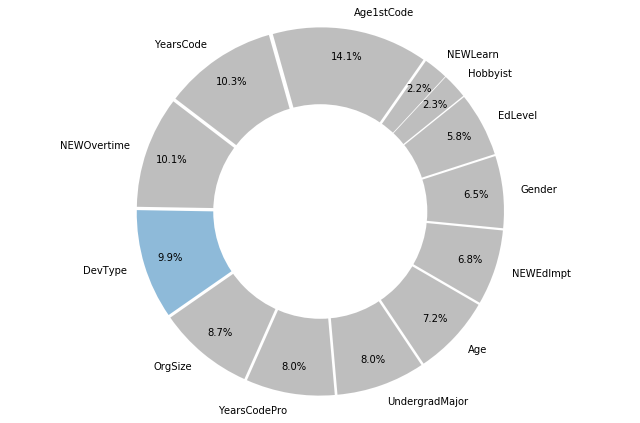

In [542]:
fig1, ax1 = plt.subplots()

# explode DevType wedge 
explode = [0.0]*len(ftr_importances_1)
explode[3] = 0.1

explode = [0.03]*len(ftr_importances_1)

colors = [Colors.get_color(7)]*len(ftr_importances_1) # ['silver']*len(ftr_importances_1)
colors[3] = Colors.get_color(0) #'cornflowerblue'

ax1.pie(ftr_importances_1, explode=explode, labels=feature_names_1, autopct='%1.1f%%',  colors=colors,
        shadow=False, startangle=55, pctdistance=0.85)

#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [632]:
# Multiple DevType features
fi_pvc2 = cbr2.get_feature_importance(
    type=catboost.EFstrType.PredictionValuesChange,
    prettified=True)
fi_pvc2

Feature Id  Importances
0                                            Country    14.420079
1                                      ConvertedComp    13.256041
2                                         Age1stCode     6.971678
3                                            OrgSize     6.962587
4                                       YearsCodePro     6.814210
5                                                Age     6.636354
6                                        NEWOvertime     6.010624
7                                          YearsCode     5.926102
8                                     UndergradMajor     4.109012
9                                             Gender     3.843482
10                                           EdLevel     3.702215
11                                         NEWEdImpt     3.555393
12                                          NEWLearn     1.817430
13                            DT_Developer, back-end     1.352297
14                            DT_Senior executive/VP     1.154643
15                           DT_Developer, front-end     1.147613
16                                       DT_Designer     1.059577
17  DT_Developer, desktop or enterprise applications     0.931383
18  DT_Data scientist or machine learning specialist     0.893912
19                                          Hobbyist     0.885119
20                          DT_Developer, full-stack     0.857376
21                              DT_Developer, mobile     0.856517
22                       DT_Data or business analyst     0.822659
23                          DT_Developer, QA or test     0.737993
24    DT_Developer, embedded applications or devices     0.709995
25                              DT_DevOps specialist     0.585589
26                                       DT_Educator     0.578662
27                    DT_Developer, game or graphics     0.513625
28                                      DT_Scientist     0.491588
29                                DT_Product manager     0.476989
30                         DT_Database administrator     0.436438
31                     DT_Engineer, site reliability     0.398868
32                            DT_Academic researcher     0.311077
33                           DT_System administrator     0.229618
34                                 DT_Engineer, data     0.227321
35                DT_Marketing or sales professional     0.219516
36                            DT_Engineering manager     0.096419

In [635]:
# Total of DevType feature impoortances
def is_devtype(s):
    return s.startswith('DT_')

sum_devtype_importance = fi_pvc2[fi_pvc2['Feature Id'].apply(is_devtype)].Importances.sum()
sum_devtype_importance

15.089674707475629

In [634]:
non_devtype = fi_pvc2[~fi_pvc2['Feature Id'].apply(is_devtype)]
non_devtype

Feature Id  Importances
0          Country    14.420079
1    ConvertedComp    13.256041
2       Age1stCode     6.971678
3          OrgSize     6.962587
4     YearsCodePro     6.814210
5              Age     6.636354
6      NEWOvertime     6.010624
7        YearsCode     5.926102
8   UndergradMajor     4.109012
9           Gender     3.843482
10         EdLevel     3.702215
11       NEWEdImpt     3.555393
12        NEWLearn     1.817430
19        Hobbyist     0.885119

In [636]:
feature_names = ['Summed\nDevTypes'] + list(non_devtype['Feature Id'])
ftr_importances = [sum_devtype_importance] + list(non_devtype['Importances'])

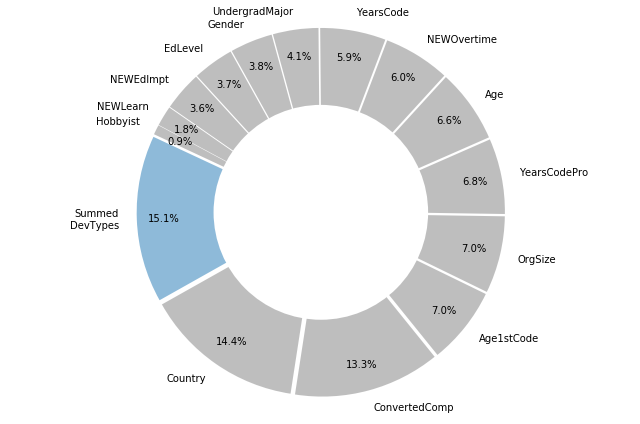

In [639]:
# Donut chart styling ideas from: https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f

fig1, ax1 = plt.subplots()

# explode first wedge - 'Summed DevTypes'
explode = [0.1]+[0.0]*len(non_devtype)

explode = [0.03]*len(ftr_importances)

colors = [Colors.get_color(7)]*len(ftr_importances)
colors[0] = Colors.get_color(0)

ax1.pie(ftr_importances, explode=explode, labels=feature_names, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=155, pctdistance=0.85)


#draw circle
centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

**LossFunctionChange Feature Importance**

For each feature the value represents the difference between the loss value of the model with this feature and without it. 

In [350]:
# Single DevType feature
fi_lfc = cbr1.get_feature_importance(
    train_pool, 
    prettified=True, 
    type=catboost.EFstrType.LossFunctionChange)
fi_lfc

Feature Id  Importances
0          DevType     0.004927
1       Age1stCode     0.004144
2   UndergradMajor     0.002844
3      NEWOvertime     0.002544
4        YearsCode     0.002302
5     YearsCodePro     0.001840
6          OrgSize     0.001375
7        NEWEdImpt     0.001373
8              Age     0.001354
9           Gender     0.001283
10         EdLevel     0.001048
11        Hobbyist     0.000407
12        NEWLearn     0.000278

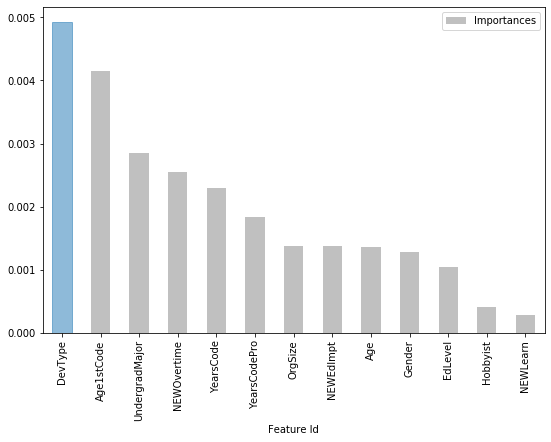

In [555]:
ax = fi_lfc.set_index('Feature Id').plot(kind='bar', color='silver');
ax.get_children()[0].set_color(Colors.get_color(0))

In [551]:
colors

['#1f77b480',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80',
 '#7f7f7f80']

In [640]:
# Multiple DevType features
fi_lfc2 = cbr2.get_feature_importance(
    train_pool2, 
    prettified=True, 
    type=catboost.EFstrType.LossFunctionChange)
fi_lfc2

Feature Id  Importances
0                                      ConvertedComp     0.012532
1                                            Country     0.004955
2                                         Age1stCode     0.003429
3                                       YearsCodePro     0.003017
4                                                Age     0.002934
5                                        NEWOvertime     0.002784
6                                            OrgSize     0.002742
7                                          YearsCode     0.002498
8                                            EdLevel     0.001388
9                                          NEWEdImpt     0.001210
10                                            Gender     0.000835
11                                    UndergradMajor     0.000680
12                                          NEWLearn     0.000595
13                            DT_Senior executive/VP     0.000537
14                            DT_Developer, back-end     0.000486
15                                       DT_Designer     0.000389
16                           DT_Developer, front-end     0.000380
17  DT_Developer, desktop or enterprise applications     0.000341
18  DT_Data scientist or machine learning specialist     0.000338
19                                          Hobbyist     0.000329
20                              DT_Developer, mobile     0.000319
21                          DT_Developer, full-stack     0.000310
22                       DT_Data or business analyst     0.000307
23    DT_Developer, embedded applications or devices     0.000292
24                          DT_Developer, QA or test     0.000283
25                              DT_DevOps specialist     0.000226
26                    DT_Developer, game or graphics     0.000201
27                                       DT_Educator     0.000194
28                                      DT_Scientist     0.000161
29                                DT_Product manager     0.000149
30                         DT_Database administrator     0.000134
31                     DT_Engineer, site reliability     0.000131
32                            DT_Academic researcher     0.000104
33                DT_Marketing or sales professional     0.000103
34                                 DT_Engineer, data     0.000074
35                           DT_System administrator     0.000066
36                            DT_Engineering manager     0.000037

In [641]:
fi_lfc2.Importances.sum()

0.045493553317406565

In [642]:
def is_devtype(s):
    return s.startswith('DT_')

fi_lfc2[fi_lfc2['Feature Id'].apply(is_devtype)].Importances.sum()

0.005562768473880819

#### Feature Importance - SHAP

In [368]:
import shap

In [373]:
fi_shap = cbr1.get_feature_importance(
    test_pool,
    type=catboost.EFstrType.ShapValues)
shap_values1 = fi_shap[:, :-1]

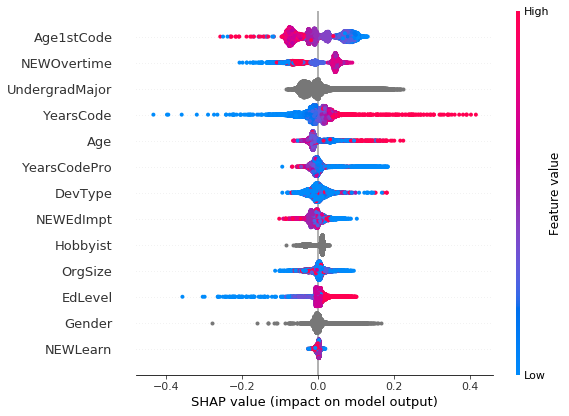

In [375]:
shap.summary_plot(shap_values1, X_test)

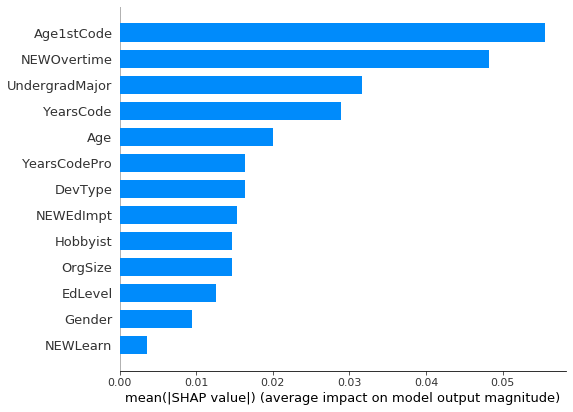

In [376]:
shap.summary_plot(shap_values1, X_test, plot_type="bar")

In [374]:
shap_values1.shape, X_test.shape

((8910, 13), (8910, 13))

In [364]:
X_test.shape

(8910, 13)

In [660]:
fi_shap = cbr2.get_feature_importance(
    train_pool2,
    type=catboost.EFstrType.ShapValues)
shap_values2 = fi_shap[:, :-1]

In [661]:
shap_values2

array([[-2.22196124e-02, -1.45123405e-02, -7.97743399e-03, ...,
         2.41305709e-04, -2.09647614e-03, -2.60826599e-04],
       [-1.62727952e-02, -4.40979020e-02, -2.23552385e-02, ...,
         2.29993157e-04, -1.93909167e-03, -4.50267873e-05],
       [ 8.30296367e-03, -1.85371346e-02,  6.70727902e-02, ...,
         6.41437565e-04, -3.91122375e-03, -2.29431596e-04],
       ...,
       [ 9.13678373e-03, -1.25621256e-02, -4.27879432e-02, ...,
        -5.50382053e-04, -2.37816220e-03, -1.81852955e-04],
       [ 4.96432234e-03, -3.26097256e-02, -3.56730248e-02, ...,
         3.92746424e-04, -1.17220919e-03, -3.90946516e-04],
       [ 4.44462658e-03, -4.91762093e-02, -8.25373059e-03, ...,
         3.55244218e-04, -3.13456983e-03, -9.30603119e-05]])

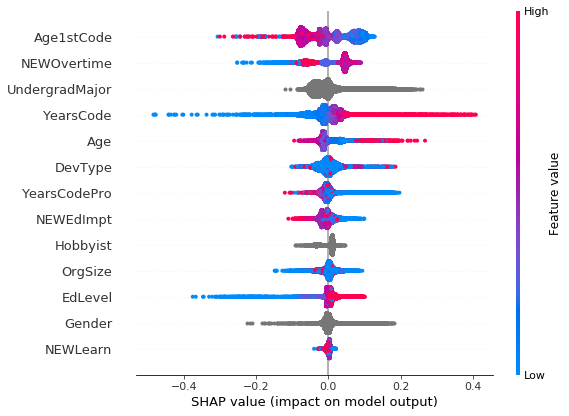

In [378]:
shap.summary_plot(shap_values2, X_train)

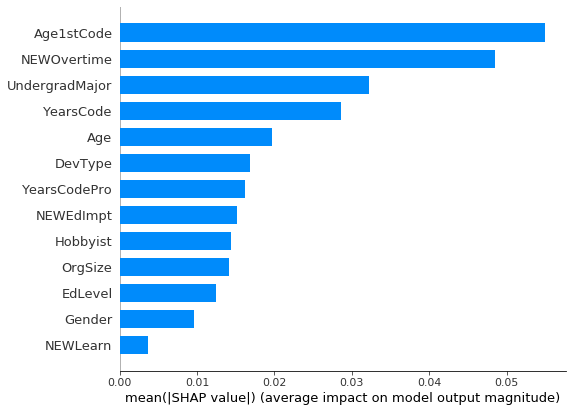

In [556]:
shap.summary_plot(shap_values2, X_train, plot_type="bar")

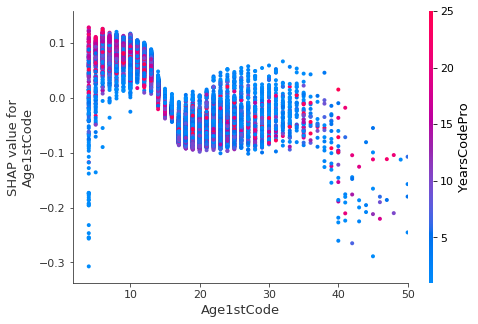

In [396]:
shap.dependence_plot("Age1stCode", shap_values2, X_train, interaction_index='YearsCodePro', xmax=50)

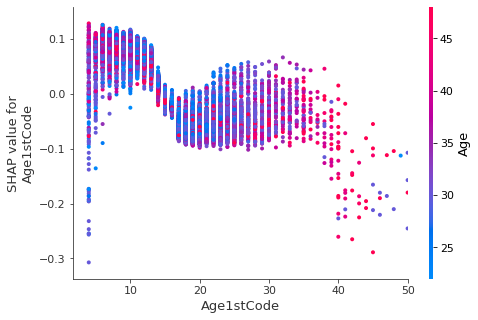

In [397]:
shap.dependence_plot("Age1stCode", shap_values2, X_train, interaction_index='Age', xmax=50)

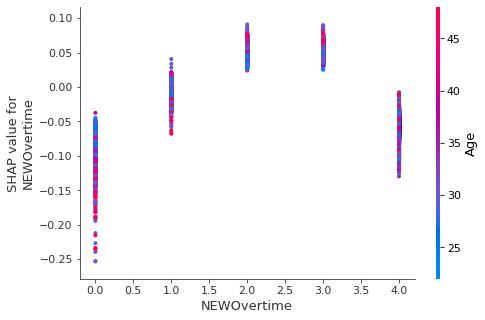

In [497]:
shap.dependence_plot("NEWOvertime", shap_values2, X_train, interaction_index='Age')

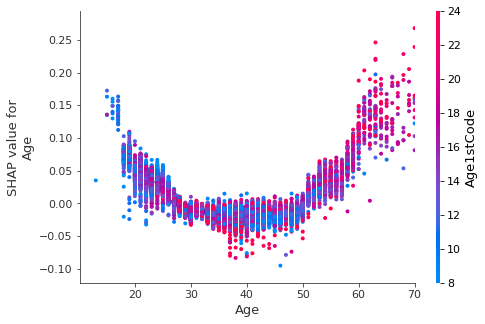

In [400]:
shap.dependence_plot("Age", shap_values2, X_train, interaction_index='Age1stCode', xmax=70)

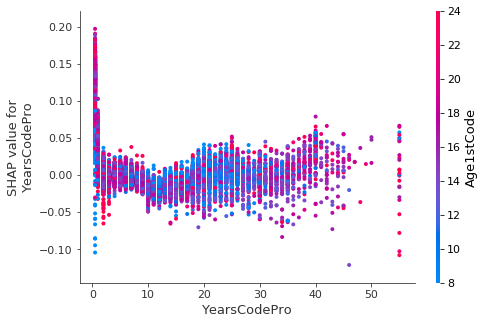

In [395]:
shap.dependence_plot('YearsCodePro', shap_values2, X_train, interaction_index='Age1stCode')

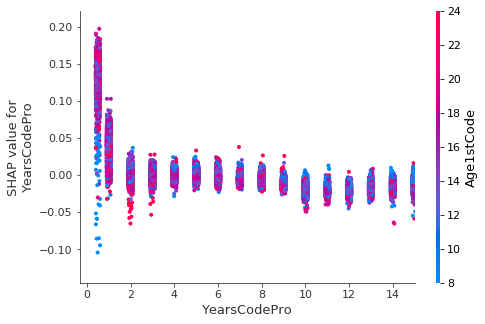

In [503]:
shap.dependence_plot('YearsCodePro', shap_values2, X_train, interaction_index='Age1stCode', xmax=15, x_jitter=0.4)

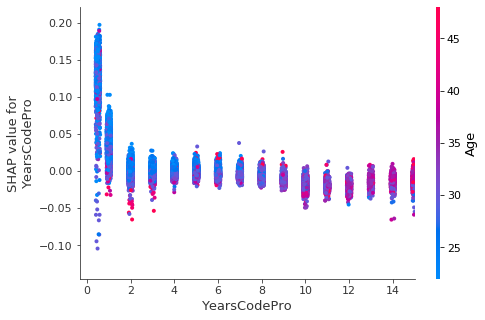

In [502]:
shap.dependence_plot('YearsCodePro', shap_values2, X_train, interaction_index='Age', xmax=15, x_jitter=0.4)

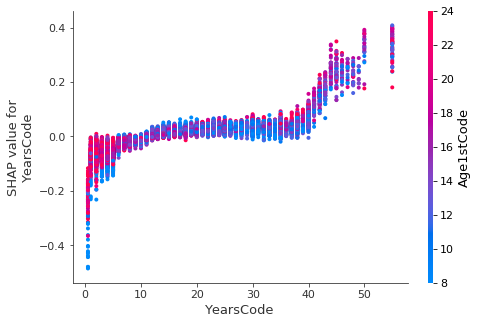

In [504]:
shap.dependence_plot('YearsCode', shap_values2, X_train, interaction_index='Age1stCode')

In [394]:
plt.rcParams['figure.figsize'] = [9, 6]

In [389]:
plt.rcParams['figure.figsize'] #= [10, 5]

[6.0, 4.0]

#### Feature Importance - SHAP - Multiple DevType Columns

In [662]:
fi_shap = cbr2.get_feature_importance(
    train_pool2,
    type=catboost.EFstrType.ShapValues)
shap_values3 = fi_shap[:, :-1]

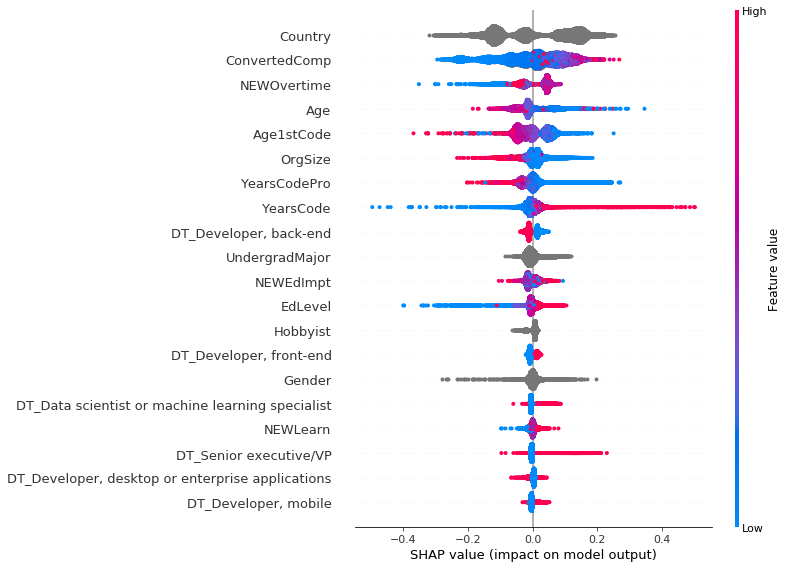

In [663]:
shap.summary_plot(shap_values3, X_train2)

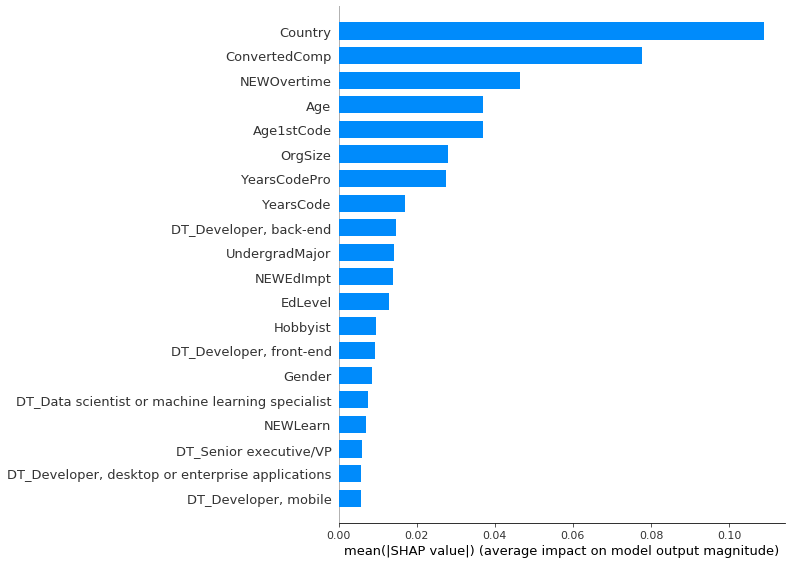

In [664]:
shap.summary_plot(shap_values3, X_train2, plot_type="bar")

In [665]:
shap_values3.shape, X_train2.shape

((35636, 37), (35636, 37))

In [681]:
named_mean_impact = list(zip(X_train2.columns, np.absolute(shap_values3).mean(axis=0)))

In [682]:
named_mean_impact

[('Hobbyist', 0.009504149026011908),
 ('Age', 0.037034088692209824),
 ('Age1stCode', 0.03700332002444258),
 ('YearsCode', 0.01689979683873064),
 ('YearsCodePro', 0.027550893485889915),
 ('Gender', 0.0086621637975062),
 ('EdLevel', 0.01288931708555109),
 ('OrgSize', 0.028005965475805295),
 ('NEWEdImpt', 0.014043850893352259),
 ('NEWLearn', 0.00710550579449211),
 ('NEWOvertime', 0.04657574834042239),
 ('UndergradMajor', 0.014243759374398859),
 ('Country', 0.1088468844985326),
 ('ConvertedComp', 0.07780186360070168),
 ('DT_Developer, back-end', 0.014717415072762056),
 ('DT_Developer, full-stack', 0.0036425899788283516),
 ('DT_Developer, front-end', 0.009255249720808753),
 ('DT_Developer, desktop or enterprise applications', 0.0057740034939924205),
 ('DT_Developer, mobile', 0.0057284105188708315),
 ('DT_DevOps specialist', 0.002188760437668028),
 ('DT_Database administrator', 0.0012473680871083537),
 ('DT_Designer', 0.004106362915220701),
 ('DT_System administrator', 0.0005349886589406934),
 ('DT_Developer, embedded applications or devices', 0.004616756246164572),
 ('DT_Data or business analyst', 0.004511571420134883),
 ('DT_Data scientist or machine learning specialist', 0.00755163854202407),
 ('DT_Developer, QA or test', 0.002041137627611677),
 ('DT_Engineer, data', 0.0005157385628489331),
 ('DT_Academic researcher', 0.0009024739806251322),
 ('DT_Educator', 0.0026467307060438683),
 ('DT_Developer, game or graphics', 0.0014813650310478074),
 ('DT_Engineering manager', 0.00031208221431709156),
 ('DT_Product manager', 0.0010420738698640921),
 ('DT_Scientist', 0.0016086104646882875),
 ('DT_Engineer, site reliability', 0.0009790110942572733),
 ('DT_Senior executive/VP', 0.006009595115647226),
 ('DT_Marketing or sales professional', 0.0005441520571901087)]

In [683]:
# sum of average model magnitude impact for DevType features
dt_impact_sum = np.sum([val for ftrname, val in named_mean_impact if ftrname.startswith('DT_')])
dt_impact_sum

0.0819580858166652

In [685]:
named_mean_impact_w_sum = [('DevType Sum', dt_impact_sum)] + [x for x in named_mean_impact if not x[0].startswith('DT_')]
named_mean_impact_w_sum

[('DevType Sum', 0.0819580858166652),
 ('Hobbyist', 0.009504149026011908),
 ('Age', 0.037034088692209824),
 ('Age1stCode', 0.03700332002444258),
 ('YearsCode', 0.01689979683873064),
 ('YearsCodePro', 0.027550893485889915),
 ('Gender', 0.0086621637975062),
 ('EdLevel', 0.01288931708555109),
 ('OrgSize', 0.028005965475805295),
 ('NEWEdImpt', 0.014043850893352259),
 ('NEWLearn', 0.00710550579449211),
 ('NEWOvertime', 0.04657574834042239),
 ('UndergradMajor', 0.014243759374398859),
 ('Country', 0.1088468844985326),
 ('ConvertedComp', 0.07780186360070168)]

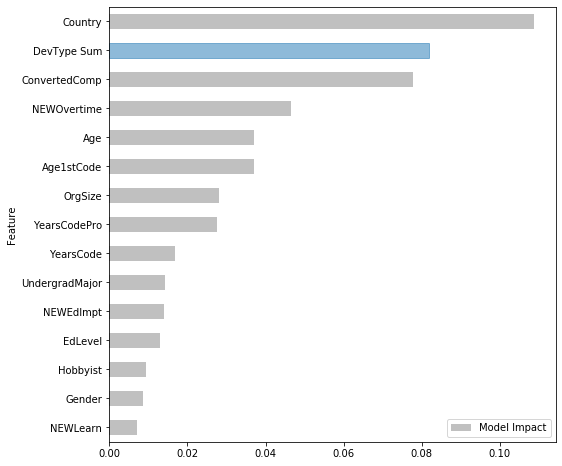

In [696]:
shap_fi_df = pd.DataFrame(data=named_mean_impact_w_sum, columns=('Feature','Model Impact'))
shap_fi_df2 = shap_fi_df.sort_values('Model Impact').set_index('Feature')
ax = shap_fi_df2.plot(kind='barh', color='silver', figsize=(8,8));
ax.get_children()[13].set_color(Colors.get_color(0))

In [ ]:
ax = fi_lfc.set_index('Feature Id').plot(kind='bar', color='silver');
ax.get_children()[0].set_color(Colors.get_color(0))

In [478]:
devtype_col_names

['DT_Developer, back-end',
 'DT_Developer, full-stack',
 'DT_Developer, front-end',
 'DT_Developer, desktop or enterprise applications',
 'DT_Developer, mobile',
 'DT_DevOps specialist',
 'DT_Database administrator',
 'DT_Designer',
 'DT_System administrator',
 'DT_Developer, embedded applications or devices',
 'DT_Data or business analyst',
 'DT_Data scientist or machine learning specialist',
 'DT_Developer, QA or test',
 'DT_Engineer, data',
 'DT_Academic researcher',
 'DT_Educator',
 'DT_Developer, game or graphics',
 'DT_Engineering manager',
 'DT_Product manager',
 'DT_Scientist',
 'DT_Engineer, site reliability',
 'DT_Senior executive/VP',
 'DT_Marketing or sales professional']

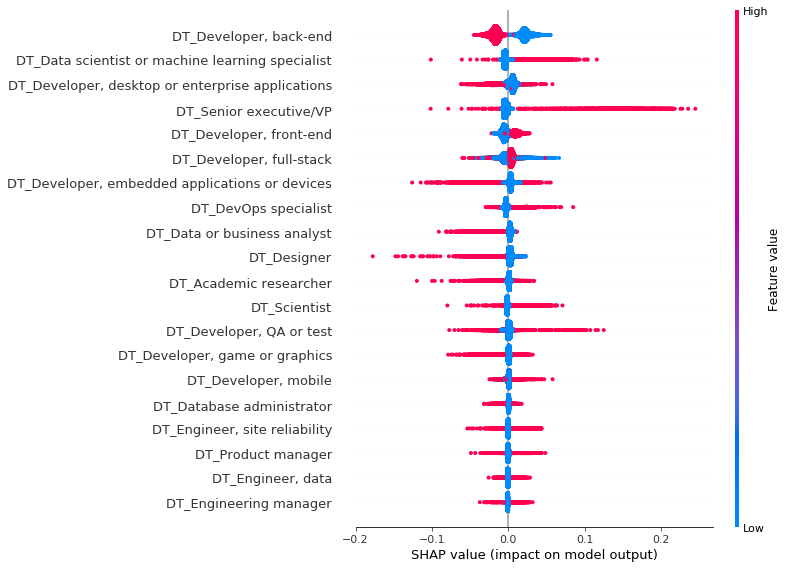

In [489]:
shap.summary_plot(shap_values3[:, 12:], X_train2.iloc[:, 12:])

In [481]:
list(enumerate(X_train2.columns))

[(0, 'Hobbyist'),
 (1, 'Age'),
 (2, 'Age1stCode'),
 (3, 'YearsCode'),
 (4, 'YearsCodePro'),
 (5, 'Gender'),
 (6, 'EdLevel'),
 (7, 'OrgSize'),
 (8, 'NEWEdImpt'),
 (9, 'NEWLearn'),
 (10, 'NEWOvertime'),
 (11, 'UndergradMajor'),
 (12, 'DT_Developer, back-end'),
 (13, 'DT_Developer, full-stack'),
 (14, 'DT_Developer, front-end'),
 (15, 'DT_Developer, desktop or enterprise applications'),
 (16, 'DT_Developer, mobile'),
 (17, 'DT_DevOps specialist'),
 (18, 'DT_Database administrator'),
 (19, 'DT_Designer'),
 (20, 'DT_System administrator'),
 (21, 'DT_Developer, embedded applications or devices'),
 (22, 'DT_Data or business analyst'),
 (23, 'DT_Data scientist or machine learning specialist'),
 (24, 'DT_Developer, QA or test'),
 (25, 'DT_Engineer, data'),
 (26, 'DT_Academic researcher'),
 (27, 'DT_Educator'),
 (28, 'DT_Developer, game or graphics'),
 (29, 'DT_Engineering manager'),
 (30, 'DT_Product manager'),
 (31, 'DT_Scientist'),
 (32, 'DT_Engineer, site reliability'),
 (33, 'DT_Senior executive/VP'),
 (34, 'DT_Marketing or sales professional')]

In [486]:
X_train2.iloc[:, 12:].columns

Index(['DT_Developer, back-end', 'DT_Developer, full-stack',
       'DT_Developer, front-end',
       'DT_Developer, desktop or enterprise applications',
       'DT_Developer, mobile', 'DT_DevOps specialist',
       'DT_Database administrator', 'DT_Designer', 'DT_System administrator',
       'DT_Developer, embedded applications or devices',
       'DT_Data or business analyst',
       'DT_Data scientist or machine learning specialist',
       'DT_Developer, QA or test', 'DT_Engineer, data',
       'DT_Academic researcher', 'DT_Educator',
       'DT_Developer, game or graphics', 'DT_Engineering manager',
       'DT_Product manager', 'DT_Scientist', 'DT_Engineer, site reliability',
       'DT_Senior executive/VP', 'DT_Marketing or sales professional'],
      dtype='object')

In [ ]:
shap_values3.

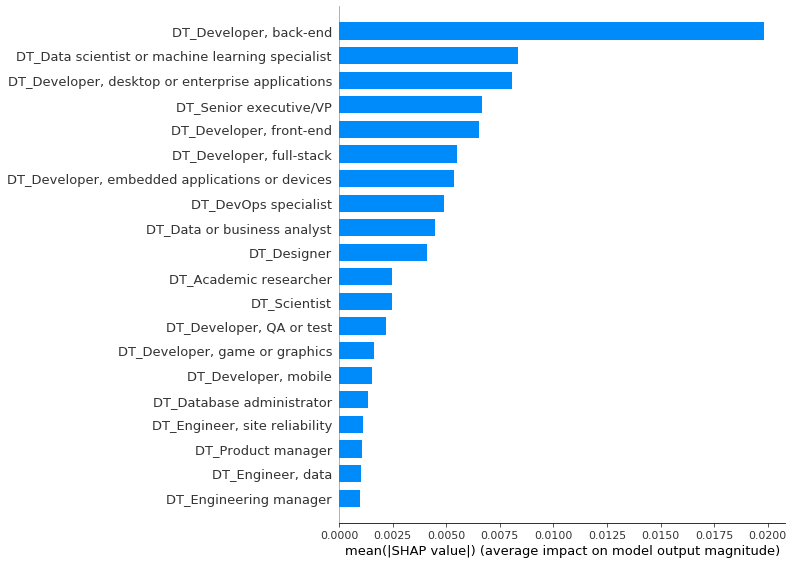

In [490]:
shap.summary_plot(shap_values3[:, 12:], X_train2.iloc[:, 12:], plot_type="bar")

## Colors

In [540]:
import matplotlib.colors as plotcolors

class Colors:
    colors_3byte = [plotcolors.get_named_colors_mapping()[x] for x in ['tab:blue',
                     'tab:orange',
                     'tab:green',
                     'tab:red',
                     'tab:purple',
                     'tab:brown',
                     'tab:pink',
                     'tab:gray',
                     'tab:olive',
                     'tab:cyan']]
    n_colors = len(colors_3byte)
    
    @classmethod
    def get_color(cl, index, is_graph=True):
        # double the number of distinct colors by using full and less saturation
        q, color_ix = divmod(index, cl.n_colors)
        less_saturation = q % 2 == 1
        
        # saturation depends on [chart_type, saturation]
        saturation_lookup = [['ff', 'a0'],    # for bar chart
                             ['80', '40']]    # for graph
        return f"{cl.colors_3byte[color_ix]}{saturation_lookup[is_graph][less_saturation]}"
        